In [15]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 22, 
    "xtick.labelsize": 18, 
    "ytick.labelsize": 18, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [16]:
def S21 (w, k, kc, Omega, DeltaE, gamma, g):
    up = kc
    down = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = 1 - up / (1j * down)
    return np.abs(t)

Omega = 2.116451
gamma = 6.5e-3

In [17]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-3, num_datos)
    kc = np.random.uniform(1e-5, 1e-4, num_datos)
    gamma = np.random.uniform(5e-3, 8e-3, num_datos)
    g = np.random.uniform(1e-2, 1.5e-2, num_datos)
    DeltaE = np.random.uniform(1.8, 2.4, num_datos)

    return k, kc, gamma, g, DeltaE

num_datos = 10000

In [18]:
def Dense_five (input_neurons, output_neurons):
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


# Crear base de datos

In [19]:
# #Creamos base de datos y guardamos en .txt
# k, kc, g, DeltaE = Parameters_generator (num_datos)
# np.savetxt('Parameters_previous-set.txt', np.column_stack((k, kc, g, DeltaE)),
#             header='\u03BA \u03BA_c g \u0394E', encoding='utf8') 

In [20]:
datos = np.loadtxt('Parameters_previous-set.txt', skiprows=1, usecols=(0, 1, 2))
k = datos[:,0]
kc = datos[:,1]
gamma = 6.5e-3
g = datos[:,2]
DeltaE = np.loadtxt('Parameters_previous-set.txt', skiprows=1, usecols=3)

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(2.09, 2.14, 2500)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))
t_values_noise = np.zeros((num_datos, len(w_values)))

for i in range (num_datos):
    t_values[i,:] = S21(w_values, k[i], kc[i], Omega, DeltaE[i], gamma, g[i])

# Añadir ruido basado en el valor mínimo de cada curva
min_values = np.min(t_values, axis=1)

# Inicializar los niveles de ruido
noise_levels = np.zeros((num_datos, len(w_values)))

# Ajustar los niveles de ruido
for i in range(num_datos):
    if min_values[i] > 0.975:
        noise_levels[i, :] = 0.15 * (1 - min_values[i])
    elif min_values[i] > 0.85:
        noise_levels[i, :] = 0.05 * (1 - min_values[i])
    else:
        noise_levels[i, :] = 0.015 * (1 - min_values[i])

# Crear el ruido y añadirlo a los valores originales
noise_matrix = np.random.normal(0, noise_levels)
t_values_noise = t_values + noise_matrix

#Seleccionamos los datos de entrenamiento y de validación
indices = np.arange(num_datos)
indices_train, indices_post = train_test_split(indices, test_size=0.2)
indices_val, indices_test = train_test_split(indices_post, test_size=0.5)

x_train = t_values_noise[indices_train]
x_val = t_values_noise[indices_val]
x_test = t_values_noise[indices_test]
y_train = datos[indices_train]
y_val = datos[indices_val]
y_test = datos[indices_test]

# Normalizamos los datos
scaler_x = RobustScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)
x_test_norm = scaler_x.transform(x_test)

scaler_y = RobustScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

#Número de neuronas de entrada y salida
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

# Prueba completa

In [21]:
# Definir listas de valores para batch_size y epochs
epochs_list = [10, 50, 100, 250, 500, 1000]
batch_size_list = [50, 100, 250, 500, 1000]

# Inicializar matrices para almacenar los resultados
losses = np.zeros((len(batch_size_list), len(epochs_list)))
training_times = np.zeros((len(batch_size_list), len(epochs_list)))

# Entrenar el modelo con diferentes combinaciones de batch_size y epochs
for i, batch_size in enumerate(batch_size_list):
    for j, epochs in enumerate(epochs_list):
        model = Dense_five(input_neurons, output_neurons)

        start_time = time.time()
        history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
                        epochs=epochs, verbose=2)
        end_time = time.time()
        training_time = end_time - start_time

        training_times[i, j] = training_time

        # Evaluar el modelo en los datos de validación
        scores = model.evaluate(x_test_norm, y_test_norm, verbose=0)
        final_loss = scores[0]
        losses[i, j] = final_loss

np.savetxt('losses_hyperparameters.txt', losses)
np.savetxt('training_times_hyperparameters.txt', training_times)

Epoch 1/10
160/160 - 6s - 37ms/step - loss: 0.2673 - mean_absolute_error: 0.4287 - val_loss: 0.2291 - val_mean_absolute_error: 0.3906
Epoch 2/10
160/160 - 1s - 4ms/step - loss: 0.2029 - mean_absolute_error: 0.3597 - val_loss: 0.1819 - val_mean_absolute_error: 0.3357
Epoch 3/10
160/160 - 1s - 4ms/step - loss: 0.1554 - mean_absolute_error: 0.3006 - val_loss: 0.1632 - val_mean_absolute_error: 0.3046
Epoch 4/10
160/160 - 1s - 4ms/step - loss: 0.1199 - mean_absolute_error: 0.2566 - val_loss: 0.1606 - val_mean_absolute_error: 0.2866
Epoch 5/10
160/160 - 1s - 4ms/step - loss: 0.0899 - mean_absolute_error: 0.2175 - val_loss: 0.1508 - val_mean_absolute_error: 0.2769
Epoch 6/10
160/160 - 1s - 4ms/step - loss: 0.0686 - mean_absolute_error: 0.1862 - val_loss: 0.1476 - val_mean_absolute_error: 0.2641
Epoch 7/10
160/160 - 1s - 4ms/step - loss: 0.0533 - mean_absolute_error: 0.1617 - val_loss: 0.1472 - val_mean_absolute_error: 0.2582
Epoch 8/10
160/160 - 1s - 4ms/step - loss: 0.0409 - mean_absolute_er

## Cuadro de valores

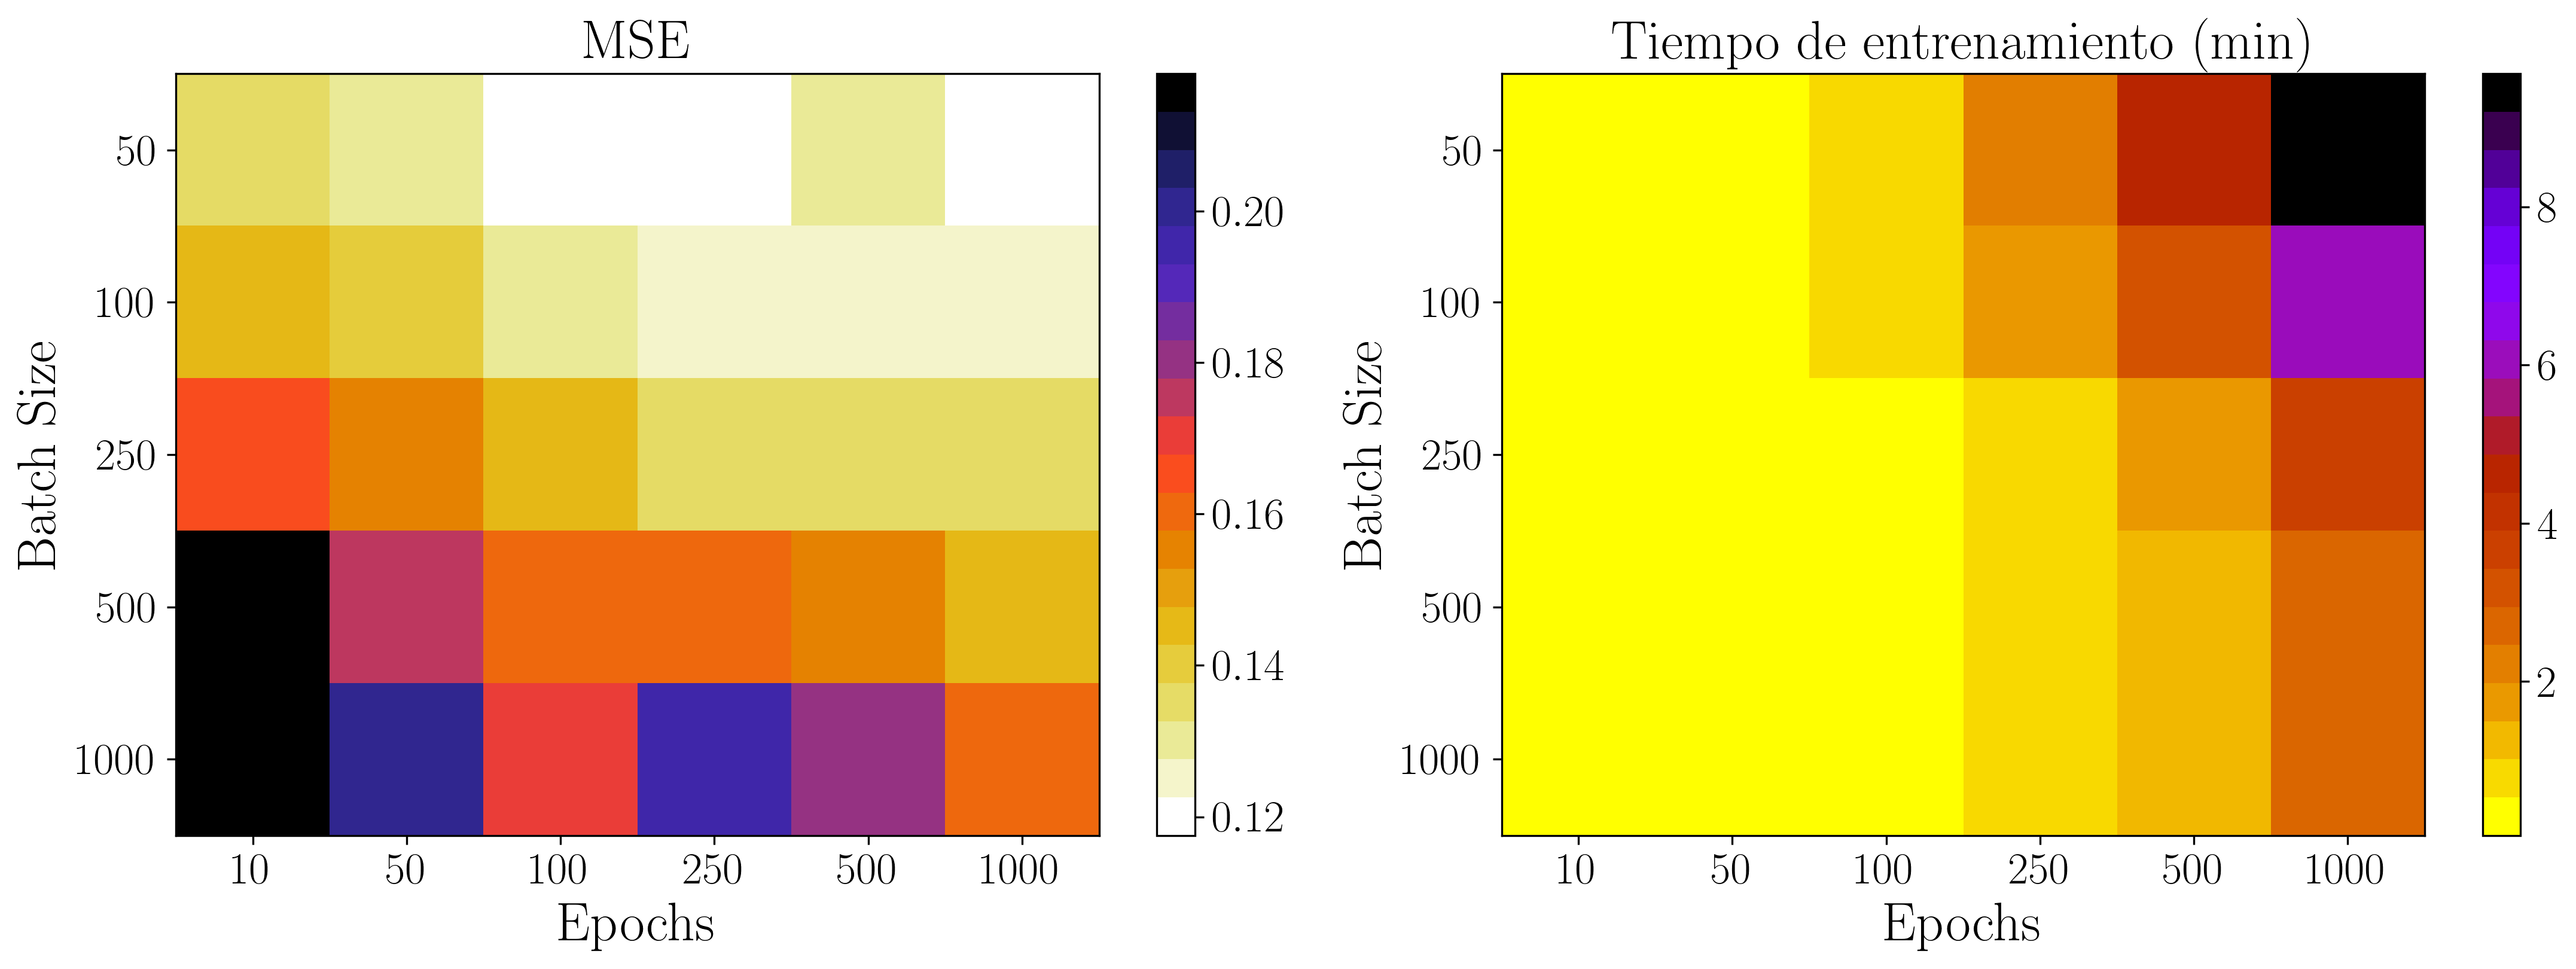

In [22]:
# Leer los archivos de texto
losses = np.loadtxt('losses_hyperparameters.txt')
training_times = np.loadtxt('training_times_hyperparameters.txt')

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Definir los valores de epochs y batch_size
epochs_list = [10, 50, 100, 250, 500, 1000]
batch_size_list = [50, 100, 250, 500, 1000]

# Crear un mapa de colores personalizado con 30 colores
colors1 = ListedColormap(plt.cm.CMRmap_r(np.linspace(0, 1, 20)))
colors2 = ListedColormap(plt.cm.gnuplot_r(np.linspace(0, 1, 20)))

# Hacer las gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5.5))

# Plotear MSE
im_mse = axs[0].imshow(losses, cmap=colors1, aspect='auto')
fig.colorbar(im_mse, ax=axs[0])
axs[0].set_xticks(np.arange(len(epochs_list)))
axs[0].set_yticks(np.arange(len(batch_size_list)))
axs[0].set_xticklabels(epochs_list)
axs[0].set_yticklabels(batch_size_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Batch Size')
axs[0].set_title('MSE')

# Plotear tiempo de entrenamiento
im_time = axs[1].imshow(training_times_minutes, cmap=colors2, aspect='auto')
fig.colorbar(im_time, ax=axs[1])
axs[1].set_xticks(np.arange(len(epochs_list)))
axs[1].set_yticks(np.arange(len(batch_size_list)))
axs[1].set_xticklabels(epochs_list)
axs[1].set_yticklabels(batch_size_list)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Batch Size')
axs[1].set_title('Tiempo de entrenamiento (min)')

plt.tight_layout()
plt.show()

# Acotamos

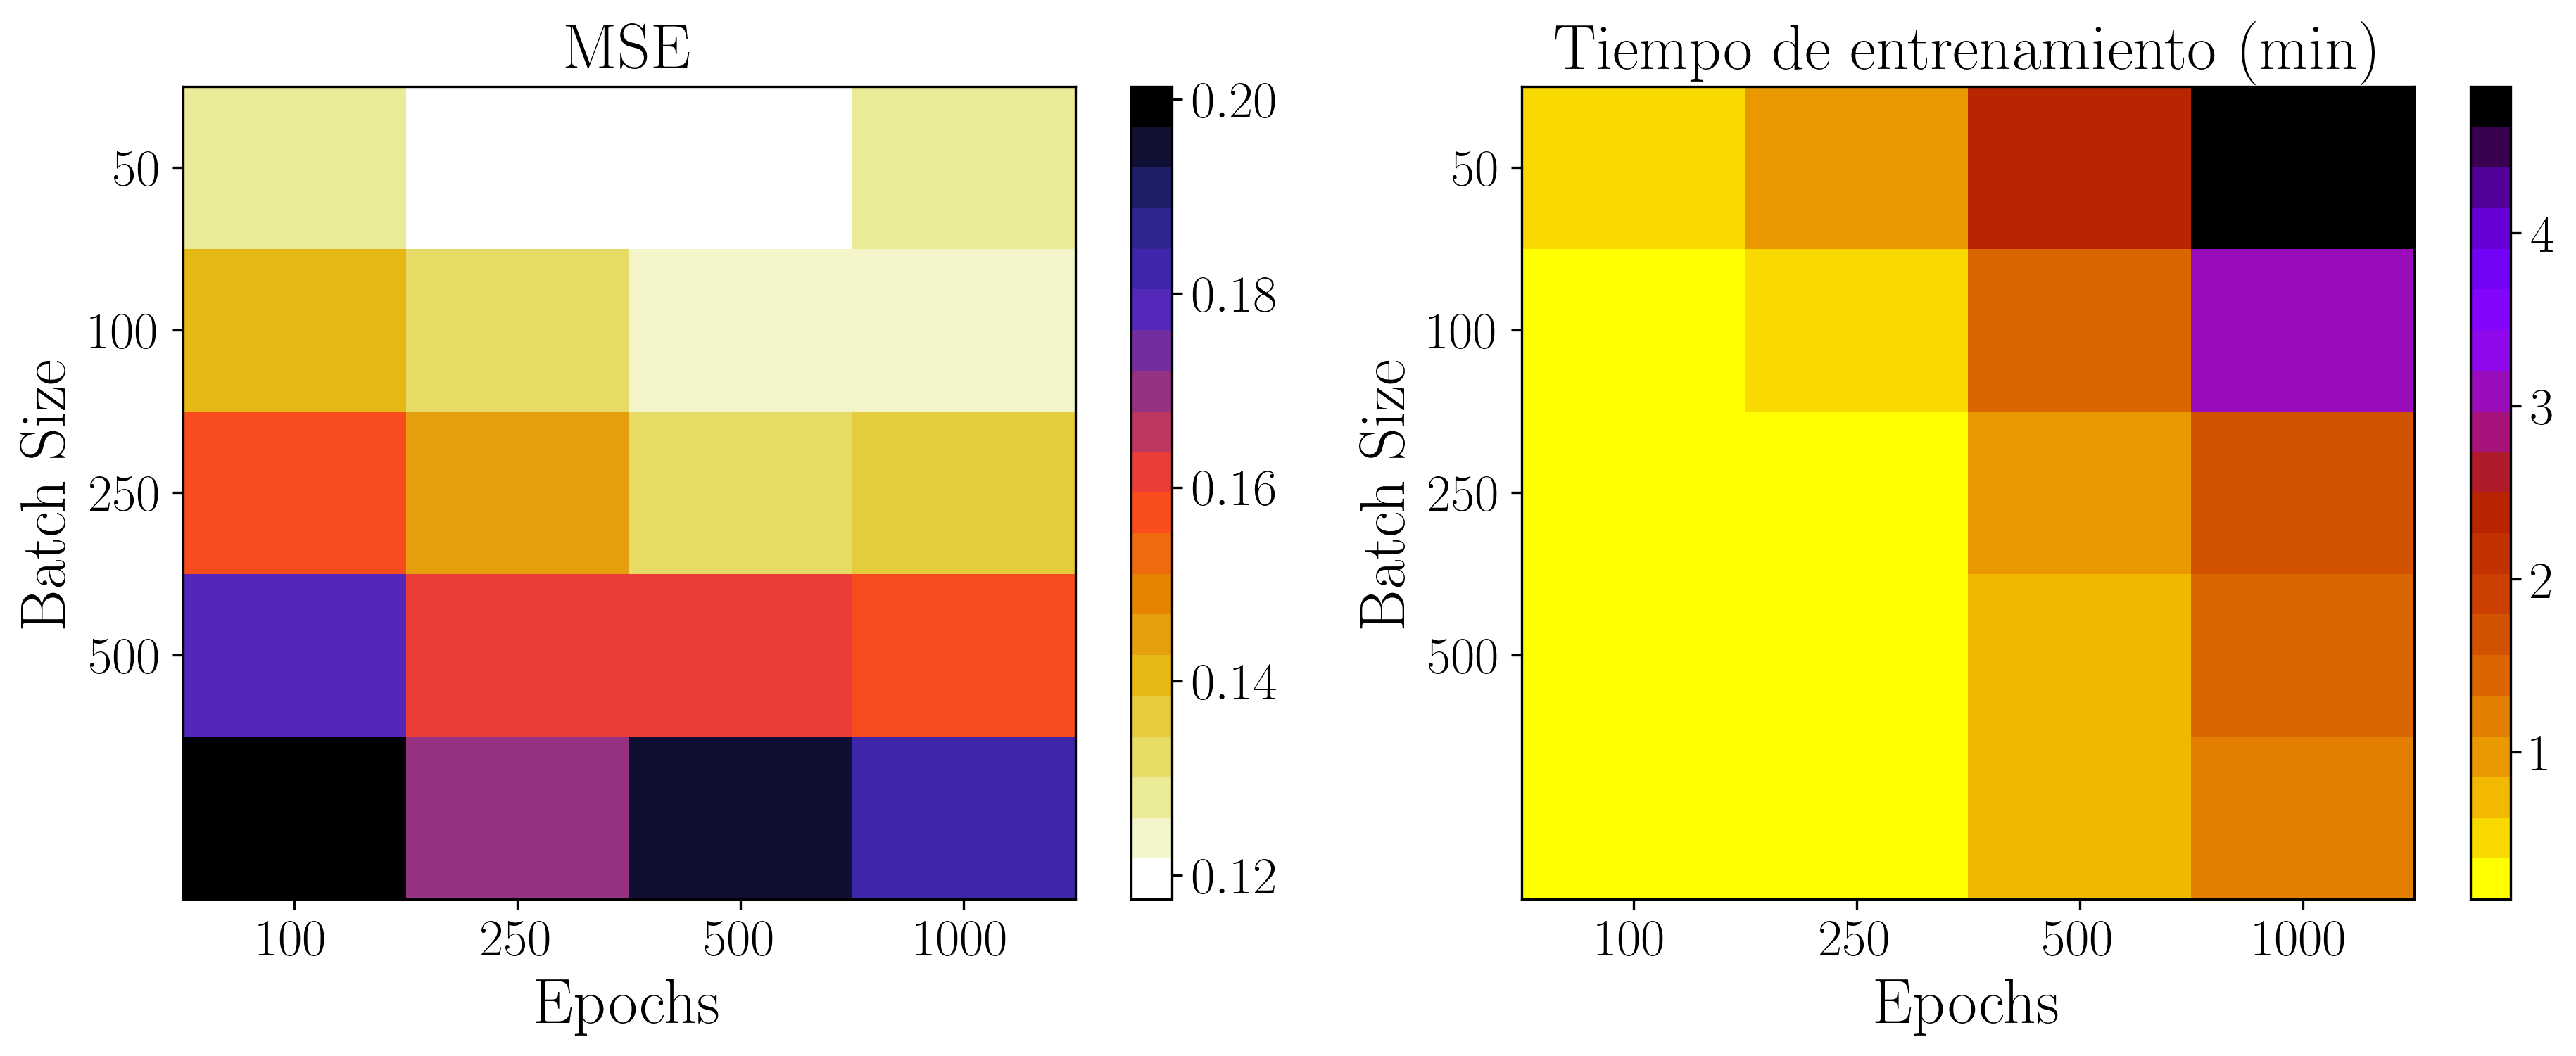

In [28]:
# Leer los archivos de texto
losses = np.loadtxt('losses_hyperparameters.txt', skiprows=0, usecols=range(1, 5))
training_times = np.loadtxt('training_times_hyperparameters.txt', skiprows=0, usecols=range(1, 5))

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Definir los valores de epochs y batch_size
epochs_list = [100, 250, 500, 1000]
batch_size_list = [50, 100, 250, 500]

# Crear un mapa de colores personalizado con 30 colores
colors1 = ListedColormap(plt.cm.CMRmap_r(np.linspace(0, 1, 20)))
colors2 = ListedColormap(plt.cm.gnuplot_r(np.linspace(0, 1, 20)))

# Hacer las gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotear MSE
im_mse = axs[0].imshow(losses, cmap=colors1, aspect='auto')
fig.colorbar(im_mse, ax=axs[0])
axs[0].set_xticks(np.arange(len(epochs_list)))
axs[0].set_yticks(np.arange(len(batch_size_list)))
axs[0].set_xticklabels(epochs_list)
axs[0].set_yticklabels(batch_size_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Batch Size')
axs[0].set_title('MSE')

# Plotear tiempo de entrenamiento
im_time = axs[1].imshow(training_times_minutes, cmap=colors2, aspect='auto')
fig.colorbar(im_time, ax=axs[1])
axs[1].set_xticks(np.arange(len(epochs_list)))
axs[1].set_yticks(np.arange(len(batch_size_list)))
axs[1].set_xticklabels(epochs_list)
axs[1].set_yticklabels(batch_size_list)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Batch Size')
axs[1].set_title('Tiempo de entrenamiento (min)')

plt.show()